In [106]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.14.0


In [107]:
import pymysql
import pandas as pd

In [108]:
host = '192.168.99.35'
port = 3306
user = 'allen'
password = 'allen'
schema = 'gambling_simulation'
sql_conn = pymysql.connect(host=host, user=user, passwd=password, db=schema, charset='utf8')

In [109]:
game_data = pd.read_sql('SELECT * FROM {}'.format('game_data'), con=sql_conn, index_col='game_id')

In [110]:
prediction_data_am = pd.read_sql('SELECT * FROM {}'.format('prediction_data_all_member'), con=sql_conn, index_col='game_id')

In [111]:
game_judgement = pd.read_sql('SELECT * FROM {}'.format('game_judgement'), con=sql_conn, index_col='game_id')

In [141]:
game_result = game_judgement['host_win_point_spread_local']

In [88]:
game_result.values.shape

(1314,)

In [11]:
len(set(game_data['play_time']))

24

In [15]:
len(set(game_data['guest']))

32

In [16]:
len(set(game_data['host']))

32

In [113]:
game_data['guest'] = pd.Categorical(game_data['guest'])

In [114]:
guest_one_hot = pd.get_dummies(game_data['guest'], prefix='guest')

In [115]:
host_one_hot = pd.get_dummies(game_data['host'], prefix='host')

In [116]:
time_one_hot = pd.get_dummies(game_data['play_time'], prefix='time')

In [228]:
train_columns_from_game_data = [
#     'national_host_point_spread',
#     'national_total_point_threshold',
#     'response_ratio_if_hit_spread_point',
    'local_host_point_spread',
    'local_host_point_spread_response_ratio',
#     'local_total_point_threshold',
#     'local_total_point_threshold_response_ratio'
]

train_columns_from_prediction = [
#     'percentage_national_point_spread_guest',
#     'percentage_national_point_spread_host',
#     'population_national_point_spread_guest',
#     'population_national_point_spread_host',

#     'percentage_national_total_point_over',
#     'percentage_national_total_point_under',
#     'population_national_total_point_over',
#     'population_national_total_point_under',

#     'percentage_local_point_spread_guest',
#     'percentage_local_point_spread_host',
    'population_local_point_spread_guest',
    'population_local_point_spread_host',

#     'percentage_local_total_point_over',
#     'percentage_local_total_point_under',
#     'population_local_total_point_over',
#     'population_local_total_point_under',

#     'percentage_local_original_guest',
#     'percentage_local_original_host',
#     'population_local_original_guest',
#     'population_local_original_host',
    'confidence'
]

In [232]:
prepared_data = game_data[train_columns_from_game_data]

In [233]:
prepared_data = prepared_data.join(guest_one_hot)

In [234]:
prepared_data = prepared_data.join(host_one_hot)

In [235]:
prepared_data = prepared_data.join(time_one_hot)

In [199]:
prepared_data = prepared_data.join(prediction_data_am[train_columns_from_prediction])

In [230]:
def get_confidence(row):
    return (row['population_local_point_spread_host'] / row['population_local_point_spread_guest'] - 1) * row['population_local_point_spread_host']

In [237]:
prediction_data_am['confidence'] = prediction_data_am[train_columns_from_prediction].apply(lambda row: get_confidence(row), axis=1)

In [236]:
prepared_data = prepared_data.join(prediction_data_am[train_columns_from_prediction].apply(lambda row: get_confidence(row), axis=1))

ValueError: Other Series must have a name

In [214]:
prepared_data.values[0].shape

(90,)

In [220]:
model = keras.Sequential()

In [221]:
model.add(keras.layers.Dense(16, activation=tf.nn.relu, input_shape=prepared_data.values[0].shape))
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 16)                1456      
_________________________________________________________________
dense_61 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 17        
Total params: 1,745
Trainable params: 1,745
Non-trainable params: 0
_________________________________________________________________


In [222]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [223]:
x_val = prepared_data[:len(prepared_data)//2]
partial_x_train = prepared_data[len(prepared_data)//2:]

y_val = game_result[:len(game_result)//2]
partial_y_train = game_result[len(game_result)//2:]

In [224]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=20,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 657 samples, validate on 657 samples
Epoch 1/50
657/657 [==============================] - 1s 2ms/sample - loss: 0.7712 - acc: 0.5190 - val_loss: 0.7042 - val_acc: 0.5099
Epoch 2/50
657/657 [==============================] - 0s 507us/sample - loss: 0.7152 - acc: 0.5008 - val_loss: 0.7002 - val_acc: 0.4855
Epoch 3/50
657/657 [==============================] - 0s 557us/sample - loss: 0.6990 - acc: 0.4977 - val_loss: 0.7030 - val_acc: 0.4795
Epoch 4/50
657/657 [==============================] - 0s 490us/sample - loss: 0.6907 - acc: 0.5282 - val_loss: 0.7012 - val_acc: 0.4855
Epoch 5/50
657/657 [==============================] - 0s 460us/sample - loss: 0.6865 - acc: 0.5205 - val_loss: 0.7020 - val_acc: 0.4840
Epoch 6/50
657/657 [==============================] - 0s 486us/sample - loss: 0.6829 - acc: 0.5419 - val_loss: 0.7015 - val_acc: 0.4764
Epoch 7/50
657/657 [==============================] - 0s 552us/sample - loss: 0.6802 - acc: 0.5388 - val_loss: 0.7023 - val_acc: 0.4886
Epoc

In [191]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [161]:
%matplotlib inline

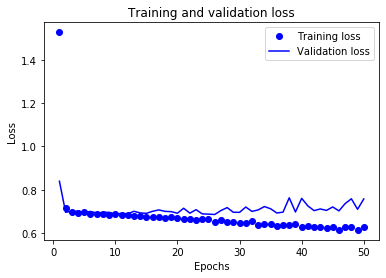

In [225]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

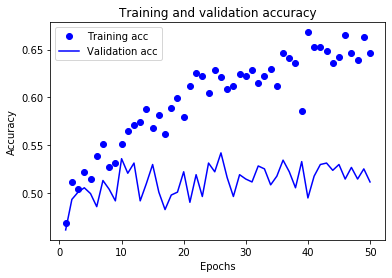

In [226]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()